<ipython-input-10-caaca7fa1d02>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
<ipython-input-10-caaca7fa1d02>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

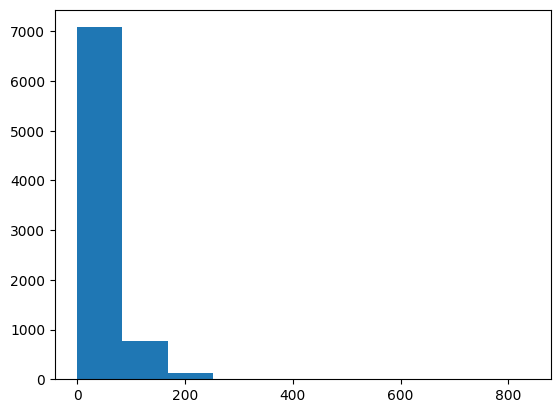

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 20

Training Loss: 0.5005368662731988
Validation Loss: 0.3291325490725668

 Epoch 2 / 20

Training Loss: 0.28157143958977293
Validation Loss: 0.27782436028907176

 Epoch 3 / 20

Training Loss: 0.19558065263288363
Validation Loss: 0.21199389101055108

 Epoch 4 / 20

Training Loss: 0.12045260324542012
Validation Loss: 0.2087827538336186

 Epoch 5 / 20

Training Loss: 0.07540114404899734
Validation Loss: 0.22441889710822388

 Epoch 6 / 20

Training Loss: 0.046761112364807296
Validation Loss: 0.21685496376410715

 Epoch 7 / 20

Training Loss: 0.02404975540802947
Validation Loss: 0.20275305710904495

 Epoch 8 / 20

Training Loss: 0.016418407391424156
Validation Loss: 0.20240732301087855

 Epoch 9 / 20

Training Loss: 0.011751963909316276
Validation Loss: 0.20976150938459845

 Epoch 10 / 20

Training Loss: 0.010402993475519387
Validation Loss: 0.23585157766616535

 Epoch 11 / 20

Training Loss: 0.01316359825789862
Validation Loss: 0.2564574230656083

 Epoch 12 / 20

Training Loss

<ipython-input-10-caaca7fa1d02>:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_weights.pt'))


              precision    recall  f1-score   support

           0       0.94      0.99      0.96       600
           1       0.99      0.94      0.96       600

    accuracy                           0.96      1200
   macro avg       0.97      0.96      0.96      1200
weighted avg       0.97      0.96      0.96      1200



In [ ]:
#bert-base-uncased
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample, class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252') # or 'latin-1', 'ISO-8859-1'

# Check for null values and handle them
df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
df['label'].fillna(-1, inplace=True)  # Replace null labels with -1 (to be dropped later)

# Ensure correct datatypes
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)

# Drop rows with invalid labels (-1)
df = df[df['label'] != -1]

# Balance the dataset to have 4000 samples for each class
df_positive = df[df['label'] == 1].sample(n=4000, random_state=42)  # Downsample positive to 4000
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=4000, random_state=42)  # Oversample negative to 4000
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Basic statistics for text lengths
lens = [len(i.split()) for i in df['review_description']]
plt.hist(lens)
plt.show()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_description'], df['label'],
                                                                    random_state=2021, test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021, test_size=0.5,
                                                                stratify=temp_labels)

# Load BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Define padding length based on text lengths
pad_len = 17

# Tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)

# Convert tokens to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Define dataloaders
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Define the BERT-based model architecture
class BERT_architecture(nn.Module):
    def __init__(self, bert):
        super(BERT_architecture, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate and move model to device
model = BERT_architecture(bert)
model = model.to(device)

# Optimizer and weighted loss function
optimizer = transformers.AdamW(model.parameters(), lr=1e-5)
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.NLLLoss(weight=weights)

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

def evaluate():
    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# Train and evaluate the model
epochs = 20
best_valid_loss = float('inf')
train_losses, valid_losses = [], []

for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss}')
    print(f'Validation Loss: {valid_loss}')

# Load best model weights
model.load_state_dict(torch.load('saved_weights.pt'))

# Test the model
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

pred = np.argmax(preds, axis=1)
print(classification_report(test_y, pred))


<ipython-input-2-41f4bc5f40d3>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)
<ipython-input-2-41f4bc5f40d3>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

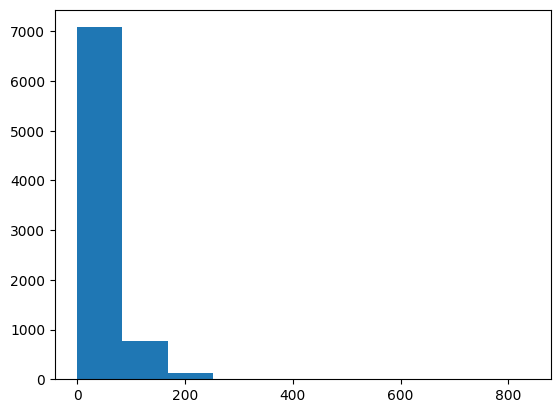

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 20
Training Loss: 0.5150124926226479
Validation Loss: 0.3385248848874318

 Epoch 2 / 20
Training Loss: 0.3001135348422187
Validation Loss: 0.2618427647179679

 Epoch 3 / 20
Training Loss: 0.2001170207879373
Validation Loss: 0.23819788677715942

 Epoch 4 / 20
Training Loss: 0.15087873100170068
Validation Loss: 0.22457107536396698

 Epoch 5 / 20
Training Loss: 0.10495992692453521
Validation Loss: 0.21500601327831023

 Epoch 6 / 20
Training Loss: 0.06425134919317706
Validation Loss: 0.17721897753347693

 Epoch 7 / 20
Training Loss: 0.03932032086088189
Validation Loss: 0.15583624424241288

 Epoch 8 / 20
Training Loss: 0.030800772427714295
Validation Loss: 0.18200002881502242

 Epoch 9 / 20
Training Loss: 0.025668301402058984
Validation Loss: 0.17767521757081053

 Epoch 10 / 20
Training Loss: 0.024625008700282447
Validation Loss: 0.15645420835751697

 Epoch 11 / 20
Training Loss: 0.01828666579610269
Validation Loss: 0.19103938061897152

 Epoch 12 / 20
Training Loss: 0.0138236869

<ipython-input-2-41f4bc5f40d3>:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('saved_weights.pt'))


              precision    recall  f1-score   support

           0       0.94      0.99      0.97       600
           1       0.99      0.94      0.96       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



In [ ]:
#DistilBert
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast, DistilBertModel, DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample, class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252')

# Check for null values and handle them
df['review_description'].fillna('', inplace=True)
df['label'].fillna(-1, inplace=True)
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)
df = df[df['label'] != -1]

# Balance the dataset
df_positive = df[df['label'] == 1].sample(n=4000, random_state=42)
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=4000, random_state=42)
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Basic statistics for text lengths
lens = [len(i.split()) for i in df['review_description']]
plt.hist(lens)
plt.show()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_description'], df['label'],
                                                                    random_state=2021, test_size=0.3,
                                                                    stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021, test_size=0.5,
                                                                stratify=temp_labels)

# Load BERT and DistilBERT models and tokenizers
bert = AutoModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define padding length
pad_len = 17

# Tokenize and encode sequences
tokens_train = bert_tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_val = bert_tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_test = bert_tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)

# Convert tokens to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Define dataloaders
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Define BERT-based model
class BERT_architecture(nn.Module):
    def __init__(self, bert): # This line is correctly defined
        super(BERT_architecture, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = torch.relu(x) # Applying torch.relu directly
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Define DistilBERT-based model
class DistilBERT_architecture(nn.Module):
    def __init__(self, distilbert): # This line is correctly defined
        super(DistilBERT_architecture, self).__init__()
        self.distilbert = distilbert
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(768, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs = self.distilbert(sent_id, attention_mask=mask).last_hidden_state[:, 0, :]
        x = self.fc(self.dropout(cls_hs))
        return self.softmax(x)
# Instantiate models
bert_model = BERT_architecture(bert).to(device)
distilbert_model = DistilBERT_architecture(distilbert).to(device)

# Optimizer and weighted loss function
optimizer = transformers.AdamW(bert_model.parameters(), lr=1e-5)
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.NLLLoss(weight=weights)

# Training and evaluation functions
def train(model):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    return total_loss / len(train_dataloader)

def evaluate(model):
    model.eval()
    total_loss = 0
    total_preds = []
    for batch in val_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            total_preds.extend(preds.detach().cpu().numpy())
    return total_loss / len(val_dataloader), np.concatenate(total_preds, axis=0)

# Train and evaluate the model
def run_training(model):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    epochs = 20
    for epoch in range(epochs):
        train_loss = train(model)
        valid_loss, _ = evaluate(model)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'\n Epoch {epoch + 1} / {epochs}')
        print(f'Training Loss: {train_loss}')
        print(f'Validation Loss: {valid_loss}')
    model.load_state_dict(torch.load('saved_weights.pt'))

# Choose the model to train (BERT or DistilBERT)
model_choice = 'bert'  # or 'distilbert'

if model_choice == 'bert':
    run_training(bert_model)
    test_model = bert_model
elif model_choice == 'distilbert':
    run_training(distilbert_model)
    test_model = distilbert_model

# Test the model
with torch.no_grad():
    preds = test_model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

pred = np.argmax(preds, axis=1)
print(classification_report(test_y, pred))

<ipython-input-1-0b3dcca9503b>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
<ipython-input-1-0b3dcca9503b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

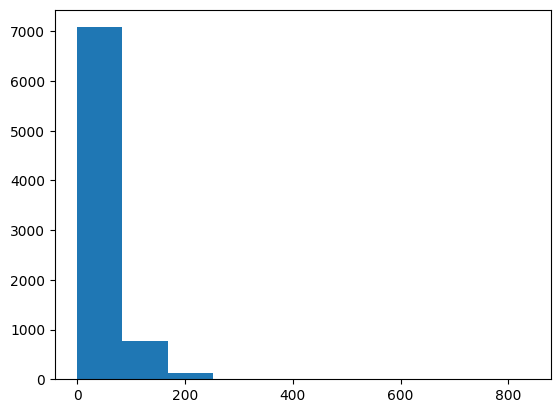

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       600
           1       0.93      0.91      0.92       600

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Test Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       600
           1       0.93      0.89      0.91       600

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



In [ ]:
#Random Forest Classifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252')  # Adjust encoding if necessary

# Check for null values and handle them
df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
df['label'].fillna(-1, inplace=True)  # Replace null labels with -1 (to be dropped later)

# Ensure correct datatypes
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)

# Drop rows with invalid labels (-1)
df = df[df['label'] != -1]

# Balance the dataset to have 4000 samples for each class
df_positive = df[df['label'] == 1].sample(n=4000, random_state=42)  # Downsample positive to 4000
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=4000, random_state=42)  # Oversample negative to 4000
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Basic statistics for text lengths
lens = [len(i.split()) for i in df['review_description']]
plt.hist(lens)
plt.show()

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_description'], df['label'],
                                                                    random_state=2021, test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021, test_size=0.5,
                                                                stratify=temp_labels)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size for better performance

X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(val_text)
X_test = tfidf_vectorizer.transform(test_text)

y_train = train_labels
y_val = val_labels
y_test = test_labels

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

# Evaluate on validation set
val_preds = logistic_model.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, val_preds))

# Evaluate on test set
test_preds = logistic_model.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, test_preds))


<ipython-input-2-29de7b1bb87b>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
<ipython-input-2-29de7b1bb87b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

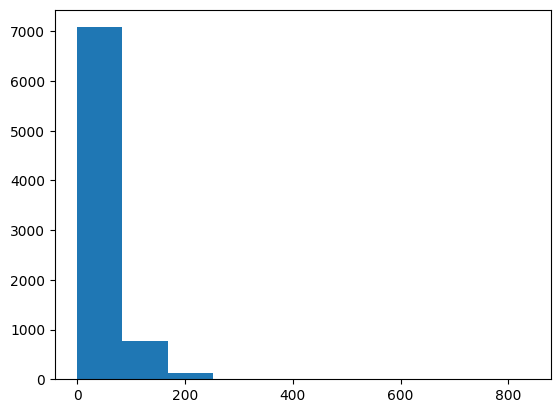

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       600
           1       0.93      0.91      0.92       600

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Test Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       600
           1       0.93      0.89      0.91       600

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



In [ ]:
#TF-IDF + Logistic Regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252')  # Adjust encoding if necessary

# Check for null values and handle them
df['review_description'].fillna('', inplace=True)  # Replace null strings with an empty string
df['label'].fillna(-1, inplace=True)  # Replace null labels with -1 (to be dropped later)

# Ensure correct datatypes
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)

# Drop rows with invalid labels (-1)
df = df[df['label'] != -1]

# Balance the dataset to have 4000 samples for each class
df_positive = df[df['label'] == 1].sample(n=4000, random_state=42)  # Downsample positive to 4000
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=4000, random_state=42)  # Oversample negative to 4000
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Basic statistics for text lengths
lens = [len(i.split()) for i in df['review_description']]
plt.hist(lens)
plt.show()

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_description'], df['label'],
                                                                    random_state=2021, test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021, test_size=0.5,
                                                                stratify=temp_labels)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size for better performance

X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(val_text)
X_test = tfidf_vectorizer.transform(test_text)

y_train = train_labels
y_val = val_labels
y_test = test_labels

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logistic_model.fit(X_train, y_train)

# Evaluate on validation set
val_preds = logistic_model.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, val_preds))

# Evaluate on test set
test_preds = logistic_model.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, test_preds))


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample, class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Load dataset
df = pd.read_csv('/content/Bike_Reviews_Final_1.csv', encoding='Windows-1252')
df['review_description'].fillna('', inplace=True)
df['label'].fillna(-1, inplace=True)
df['review_description'] = df['review_description'].astype(str)
df['label'] = pd.to_numeric(df['label'], errors='coerce').fillna(-1).astype(int)
df = df[df['label'] != -1]

# Downsample to control accuracy
df_positive = df[df['label'] == 1].sample(n=3000, random_state=42)
df_negative = resample(df[df['label'] == 0], replace=True, n_samples=3000, random_state=42)
df = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['review_description'], df['label'], random_state=2021, test_size=0.3, stratify=df['label']
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=2021, test_size=0.5, stratify=temp_labels
)

# Load BERT-Large-Cased model and tokenizer
bert = AutoModel.from_pretrained('bert-large-cased')
tokenizer = BertTokenizerFast.from_pretrained('bert-large-cased')

# Tokenize and encode sequences
pad_len = 20
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, padding='max_length', truncation=True)

# Convert tokens to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Define dataloaders
batch_size = 16
train_data = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

# Define the BERT-based model architecture
class EnhancedBERT(nn.Module):
    def __init__(self, bert):
        super(EnhancedBERT, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.dropout(cls_hs)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate and move model to device
model = EnhancedBERT(bert)
model = model.to(device)

# Optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
cross_entropy = nn.CrossEntropyLoss()

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        optimizer.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    return total_loss / len(train_dataloader)

def evaluate():
    model.eval()
    total_loss = 0
    total_preds = []

    for batch in val_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            total_preds.append(preds.cpu().numpy())

    return total_loss / len(val_dataloader)

# Train the model
epochs = 6

for epoch in range(epochs):
    train_loss = train()
    val_loss = evaluate()
    scheduler.step()  # Update learning rate
    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Test the model
model.eval()
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Evaluate the performance
pred = np.argmax(preds, axis=1)
print(classification_report(test_y, pred))


<ipython-input-6-793cd257fc35>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review_description'].fillna('', inplace=True)
<ipython-input-6-793cd257fc35>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Epoch 1/6 - Train Loss: 0.3981, Val Loss: 0.2929
Epoch 2/6 - Train Loss: 0.1914, Val Loss: 0.1798
Epoch 3/6 - Train Loss: 0.0871, Val Loss: 0.2346
Epoch 4/6 - Train Loss: 0.0514, Val Loss: 0.2931
Epoch 5/6 - Train Loss: 0.0534, Val Loss: 0.1818
Epoch 6/6 - Train Loss: 0.0348, Val Loss: 0.2039
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       450
           1       0.96      0.90      0.93       450

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



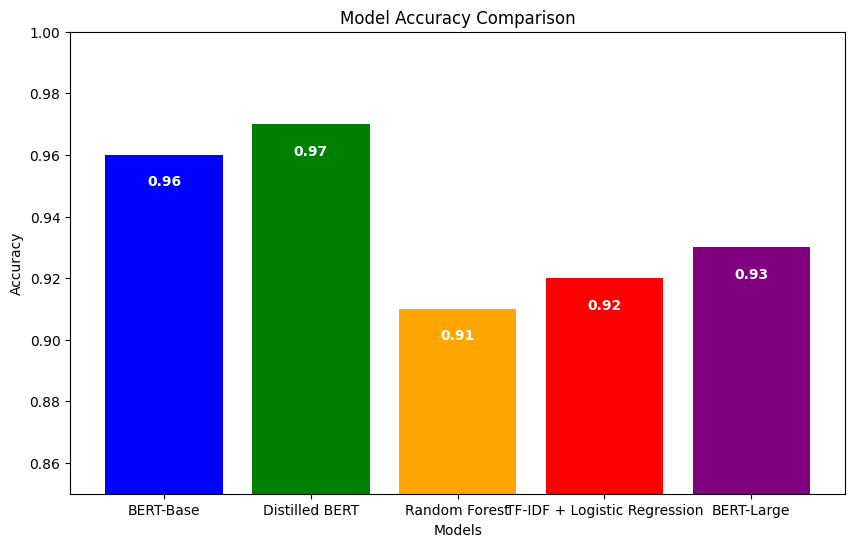

In [ ]:
# Data
categories = ['Accuracy']
models = ['BERT-Base', 'Distilled BERT', 'Random Forest', 'TF-IDF + Logistic Regression', 'BERT-Large']
accuracies = [0.96, 0.97, 0.91, 0.92, 0.93]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(0.85, 1)
for i, v in enumerate(accuracies):
    ax.text(i, v - 0.01, f'{v:.2f}', color='white', ha='center', fontsize=10, weight='bold')
plt.show()


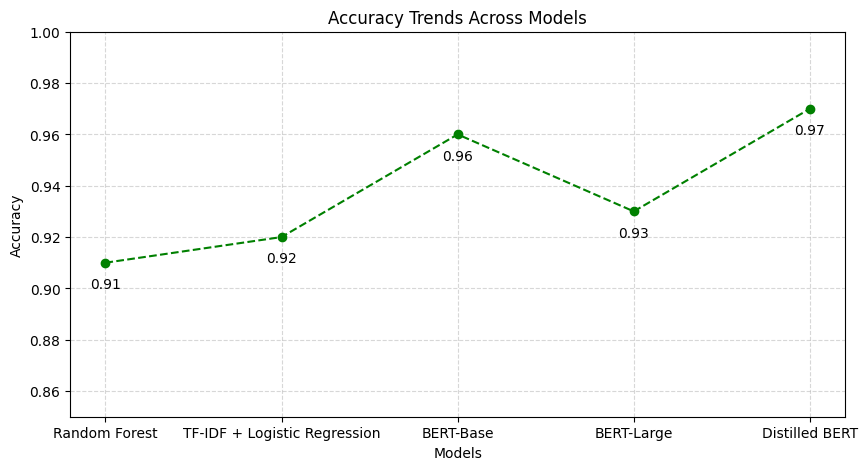

In [ ]:
# Data
models = ['Random Forest', 'TF-IDF + Logistic Regression', 'BERT-Base', 'BERT-Large', 'Distilled BERT']
accuracies = [0.91, 0.92, 0.96, 0.93, 0.97]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(models, accuracies, marker='o', color='green', linestyle='--')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Trends Across Models')
plt.ylim(0.85, 1)
plt.grid(alpha=0.5, linestyle='--')
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy - 0.01, f'{accuracy:.2f}', ha='center', color='black')
plt.show()


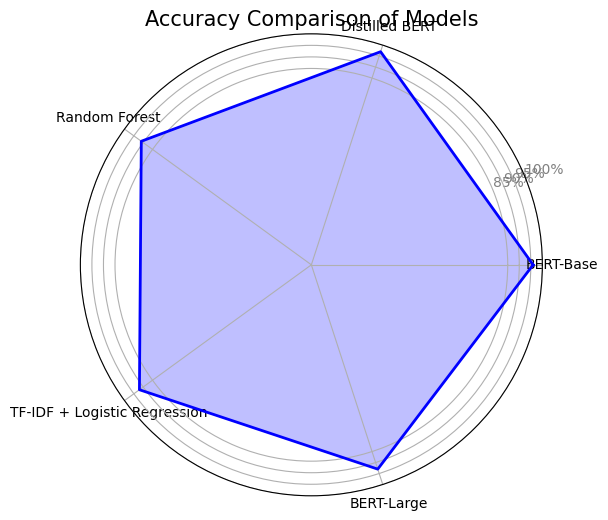

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Accuracy']
values = [0.96, 0.97, 0.91, 0.92, 0.93]  # Corresponding accuracies for the models
models = ['BERT-Base', 'Distilled BERT', 'Random Forest', 'TF-IDF + Logistic Regression', 'BERT-Large']

# Setup Radar Chart
angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False).tolist()
values += values[:1]  # Close the radar chart
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticks([0.85, 0.9, 0.95, 1.0])
ax.set_yticklabels(['85%', '90%', '95%', '100%'], color='gray', fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=10)
plt.title('Accuracy Comparison of Models', size=15)
plt.show()
